<h1 align="center"><font face = "Times New Roman" size = "80">H.264 Video Compression</font></h1>
<h2 align="center"><font face = "Times New Roman" size = ""> Information theory and coding</font></h2>
<h3 align="center"><font face = "Times New Roman"> Fall 2019</font></h3>
<h5 align="center"><font face = "Times New Roman"">Alaa Mohamed Roshdy&nbsp 201600031</font></h5>
<h5 align="center"><font face = "Times New Roman">Mohamed Adham Mahrous&nbsp 201601078</font></h5>
<h5 align="center"><font face = "Times New Roman">Mohamed Mostafa Hamed&nbsp 201600236</font></h5>
<h5 align="center"><font face = "Times New Roman">Mohamed Kasem Saber&nbsp 201601144</font></h5>




---



## Introduction

H.264 is a highly common video compression technique that is widely used with the common and well known format of .mp4. In this project, we implement a fully working encoder and decoder for the H.264 technique. In order to explore our results, we compare different compression rates by choosing how many reference frames to choose which shall give different video qualities that degenerate at high compression rates. Throught the paper, we use a block_size of 16 x 16 for the reference frames to carry out the motion estimation and compensation (predicting frames). Although the code is modular and can work with any given block size, we have chosen 16 x 16 to be our test case. 


In [2]:
from matplotlib import pyplot as plt
import cv2
from IPython.display import Video # To display the video in the notebook
import numpy as np

In [3]:
# Play the video
Video("mountain.mp4")

## Video Compression

This diagram represents the encoding process. There are 2 main models in this scheme, namely, temporal and spatial models. Temporal being the time component which is where we find the highest redundancy and where lies most of the potential for compression. Leveraging the redundancy in adjacent frames in a smart and efficient way can provide high compression capabilities with little damage to the data. On the other hand, the spatial model offers yet another way to compress the data even further. Shown below is the block diagram used to implement the video compression. ![video_compression pipeline diagram](images/block_diagram.jpg) (Reference to H.264 and MPEG 4 Video Compression book by Iain Richardson)

We first read the video in a for loop and store each frame in the video in an array called vid_frame. Then, this 

In [6]:
import numpy as np
from PIL import Image

import Encoder as E
import julia 
jl = julia.Julia()
jl.include('bac.jl')
jl.include('motion_estimation.jl')
path="mountain.mp4"
predictedPerRef=5 
no_frames = 5
Resolution=1
vid_frame=E.get_video_frames(path,no_frames,Resolution)
ref_frames=vid_frame[::predictedPerRef]
vid_mv=[]
vid_residuals=[]
vid_predicted=[]
c = 1
for j in range(0,np.int(len(vid_frame)/predictedPerRef)):

    #Reshaping the reference frames to use in the coming blocks
    im_ref,_,_=E.get_sub_images(E.reshape_image(ref_frames[j][0]))

    for i in range(0,predictedPerRef-1):
        #Reshaping the current frame 
        current_im_blocks, nrows, ncols = E.get_sub_images(E.reshape_image(vid_frame[c][0]))
        
        #Motion estimation 
        mv = jl.motion_estimation_to_all(ref_frames[j][0], current_im_blocks, nrows, ncols, 32)

        #Motion Compensation
        p_image = E.predict(im_ref,mv, ref_frames[0][0].shape[0], ref_frames[0][0].shape[1])

        #Calculating the residuals
        residual_frame=E.residual(vid_frame[c][0],p_image)
        # appending motion vectors and residual frames to change into bits
        vid_mv.append(mv)
        vid_residuals.append(residual_frame)
        vid_predicted.append(p_image)

 The saved video array has dimensions:  (5,)
Dimensions of the ref image is  (720, 960)
Dimensions of the ref divided is (2700, 16, 16)


Text(0.5, 1.0, 'Sample macroblock')

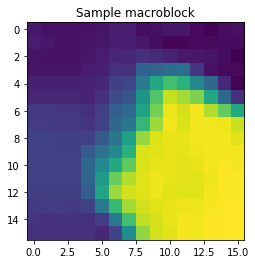

In [15]:
# Print out some statistics about the frames.
import Encoder as e
im_blocks_ref, n_rows, n_cols = e.get_sub_images(e.reshape_image(vid_frame[0][0]))
im_blocks_p, __, __ = e.get_sub_images(e.reshape_image(vid_frame[0][0]))
print('Dimensions of the ref image is ', vid_frame[0][0].shape)
print('Dimensions of the ref divided is', im_blocks_ref.shape)

plt.imshow(im_blocks_ref[1700])
plt.title("Sample macroblock")